In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import fft
from scipy import optimize
import scipy.stats as sts

### Эксперимент 2

In [62]:
def plot_signal(x, y, plotable, s, lim) -> np.ndarray:
    """_summary_

    Args:
        data_x (_type_): _description_
        data_y (_type_): _description_
        plotable (_type_): _description_
        s (_type_): _description_

    Returns:
        np.ndarray: координаты пиков для интерполяции
        np.ndarray: интерполянд
        x_line
    """
    x_line = np.linspace(*lim, 1000)
    interpolation = interpolate.UnivariateSpline(x, y, s = s)
    peaks_indecies, _ = signal.find_peaks(interpolation(x_line), 
                                          width = 10, 
                                          distance = 100,
                                          height = 0.2)
    
    # plotable.set_xticks(np.arange(-0.5, 0.5, 0.05))
    plotable.set_xlim(*lim)
    plotable.plot(x_line, interpolation(x_line))
    plotable.grid(ls = ':')
    plotable.set_ylim(np.min(y) - 0.4, np.max(y) + 0.7)
    plotable.scatter(x_line[peaks_indecies], 
                interpolation(x_line)[peaks_indecies],
                s = 40,
                color = 'red',
                edgecolors='black')
    plotable.set_title("Экспериментальный сигнал", fontsize = 12)
    plotable.set_xlabel(r"Время [с $10^{-6}$]", fontsize = 12)
    plotable.set_ylabel(r"Напряжение U [В]", fontsize = 12)
    return peaks_indecies, interpolation(x_line), x_line
def plot_forieer(x_line, ax_forier, interpolation):
    fft_freq = fft.fftfreq(n = len(x_line), d = (x_line[11] - x_line[10]))
    amps = np.abs(fft.fft(interpolation))
    mask = (fft_freq > 0) * (fft_freq < 1000)
    ax_forier.plot(fft_freq[mask], amps[mask])
    ax_forier.set_xlim(0, 1)
    nu_max = fft_freq[mask][np.argmax(amps[mask])] #МГц
    ax_forier.axvline(x = nu_max,
                      label = f"f = {nu_max:.3f} МГц\nv = {2 * 2.9 * nu_max * 1e2:.1f} см/c",
                      color = 'black',
                      linestyle = '--')
    ax_forier.legend(fontsize = 12)
    ax_forier.set_title("Спектр сигнала", fontsize = 12)
    ax_forier.set_xlabel("Частота [МГц]", fontsize = 12)
    ax_forier.set_ylabel("Амплитуда [отн.ед]", fontsize = 12)

   
    return nu_max

def plot_log(x_line, interpolation, peaks_indecies, nu_max, ax_loglog):
    peaks_x, peaks_y_log = x_line[peaks_indecies], np.log(interpolation[peaks_indecies])
    MNK = sts.linregress(x = peaks_x, y = peaks_y_log)
    ax_loglog.plot(x_line, 
                   MNK.slope * x_line + MNK.intercept, 
                   label = f'$b + at, a = {MNK.slope:.2f}$' + '  $10^{-6} / сек$\n' + r"$\alpha = " + f"{-MNK.slope/(2 * 2.9 * nu_max):.2f} $" + " $см^{-1}$")
    ax_loglog.scatter(x_line[peaks_indecies], peaks_y_log, color = 'red', edgecolors='black')
    ax_loglog.legend()
    ax_loglog.set_title("Нахождение коэффициента затухания", fontsize = 12)
    ax_loglog.set_xlabel("Время [с $10^{-6}$]", fontsize = 12)
    ax_loglog.set_ylabel(r"$\operatorname{log}U$", fontsize = 16)
    return -MNK.slope/(2 * 2.9 * nu_max)

fft_freq = fft.fftfreq(n = len(x_line), d = (x_line[11] - x_line[10]))
    amps = np.abs(fft.fft(interpolation))
    mask = (fft_freq > 0) * (fft_freq < 100)
    ax_forier.plot(fft_freq[mask], amps[mask])

In [67]:
freq = [420, 500, 600, 700, 800, 900]
limits = [(-0.15, 0.3), 
          (-0.15, 0.18),
          (-0.4, -0.1), 
          (-0.27, 0.1), 
          (-0.43, -0.05), 
          (-0.34, 0)]

for i in range(len(limits)):
    limits[i] = (limits[i][0] * 100, limits[i][1] * 100)
alpha = []
scale_x = 10 #мкс
s_values = [2, 10, 30, 0.5, 12, 5]
for f, lim, s in zip(freq, limits, s_values):
    fig = plt.figure(figsize=(10, 5), dpi = 200)
    ax_signal = fig.add_subplot(2, 2, 1)
    ax_forier = fig.add_subplot(2, 2, 3)
    ax_loglog = fig.add_subplot(1, 2, 2)
    data = pd.read_csv(f'experiment_2/{f}.csv')
    data.x *= scale_x
    data.y += np.abs(np.min(data.y))
    data = data[(data.x > lim[0])]
    data = data[(data.x < lim[1])]
    data = data.sort_values(by = 'x')
    x, y = data.x.to_numpy(), data.y.to_numpy()

    peaks_indecies, interpolation, x_line = plot_signal(x, y, ax_signal, s, lim)
    nu_max = plot_forieer(x_line, ax_forier, interpolation)
    
    alpha.append(plot_log(x_line, interpolation, peaks_indecies, nu_max, ax_loglog))

   

    
    fig.suptitle(r"$\nu = " + f"{f}$ МГЦ", fontsize = 16)
    fig.tight_layout()

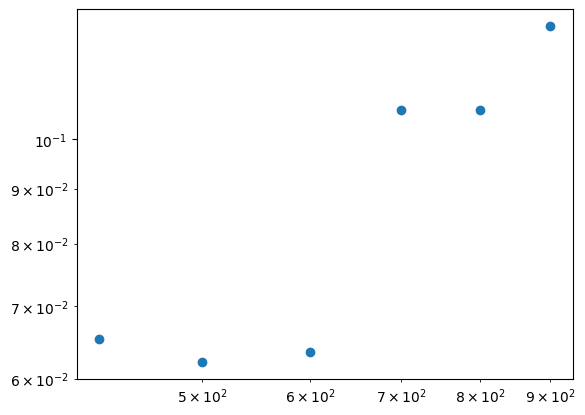

In [66]:
plt.scatter(freq, alpha)
plt.xscale('log')
plt.yscale('log')